<a href="https://colab.research.google.com/github/HedersonSantos/Noticias/blob/main/classica/classificacaoNoticiasW2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794 (medio)
#https://www.kdnuggets.com/2018/11/multi-class-text-classification-model-comparison-selection.html/2 (fraco)
#https://realpython.com/python-keras-text-classification/ (fraco)
#https://sabber.medium.com/classifying-yelp-review-comments-using-lstm-and-word-embeddings-part-1-eb2275e4066b (fraco)

import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from multiprocessing import Pool, Process
import multiprocessing as mp
from google.colab import files, drive
from pathlib import Path
import io, os
import pickle
import pyarrow.parquet as pq
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)



import nltk, re
from nltk import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
import gensim
import gensim.downloader as gensim_api


from scipy.stats import uniform, randint

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import cross_val_score, KFold, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline


from sklearn import feature_selection
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, \
                            recall_score, confusion_matrix, \
                            plot_confusion_matrix, classification_report, \
                            balanced_accuracy_score, cohen_kappa_score, matthews_corrcoef, \
                            auc, roc_curve, precision_recall_curve

from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K

# Obtendo dataset de noticias tratadas em preProcessamento_noticias

In [2]:
#!rm news.*
#!wget https://raw.githubusercontent.com/HedersonSantos/Noticias/main/news.zip
#!unzip news.zip
drive.mount('/gdrive')
%cd /gdrive/My\ Drive/Colab\ Notebooks/
!ls -lh 


Mounted at /gdrive
/gdrive/My Drive/Colab Notebooks
total 974K
drwx------ 2 root root 4.0K Aug 31 12:22  amostra_news_integrada
-rw------- 1 root root  57K Jul 13 19:50  artigosWikibr.ipynb
drwx------ 2 root root 4.0K Aug 30 22:59  bertimbau
-rw------- 1 root root  37K Aug  1 23:19 'BERTimbau_com_amostras (1).ipynb'
-rw------- 1 root root 158K Sep  2 16:41  BERTimbau_com_amostras.ipynb
drwx------ 2 root root 4.0K Aug  7 13:00  bertimbau_resp
drwx------ 2 root root 4.0K Sep  1 13:17  classica_resp
-rw------- 1 root root 125K Sep  6 10:58  classificacaoNoticiasW2vec
-rw------- 1 root root 170K Aug  7 17:47 'Cópia de BERTimbau_Testes (1).ipynb'
-rw------- 1 root root  98K Aug  7 15:29 'Cópia de BERTimbau_Testes (2).ipynb'
-rw------- 1 root root  72K Aug  1 12:19 'Cópia de BERTimbau_Testes (3).ipynb'
-rw------- 1 root root  46K Aug  1 11:45 'Cópia de BERTimbau_Testes (4).ipynb'
-rw------- 1 root root 168K Aug 23 20:02 'Cópia de BERTimbau_Testes.ipynb'
drwx------ 2 root root 4.0K Aug 1

In [3]:
%cd /gdrive/My\ Drive/Colab\ Notebooks/
!ls ./amostra_news_integrada/amostra_5


/gdrive/My Drive/Colab Notebooks
test.csv  train.csv  valid.csv


In [ ]:
mp.cpu_count()

2

# Funções para processamento de Linguagem Natural

In [51]:
def download_pt_stopWords():

  '''download das stopwords '''
  nltk.download('stopwords') #stopwords
  nltk.download('rslp')  #stemming
        
def removeStopWords( texto, excluirWords:list=None):
  '''remove as stopwords do texto. Novas stopwords podem ser adicionadas através da lista excluirWords'''
  naoQueridas = nltk.corpus.stopwords.words('portuguese')
  if not excluirWords==None:
    naoQueridas.extend(excluirWords)
  naoQueridas = list(set(naoQueridas))
  palavras = [i for i in texto.split() if not i.lower() in naoQueridas]
  return (" ".join(palavras))

def aplicaStemming( texto):
  ''' obtém o radical das palavras do vocabulário'''
  stemmer = nltk.stem.RSLPStemmer()
  palavras = []
  for w in texto.split():
      palavras.append(stemmer.stem(w))
  return (" ".join(palavras))

def removeCaracteresNaoDesejados(texto):
  textoLimpo = re.sub(r"http\S+", "", texto)
  textoLimpo = re.sub(r"www\..+\..+", "", texto)
  textoLimpo = re.sub(r"[^a-zA-ZáÁéÉíÍóÓúÚãÃàÀôâÂêÊôÔçÇ ]", "", texto)
  return textoLimpo

def retornaVetorizacao(X,pct_min=1, pct_max=1, n_grams=(1,1), excluirSW:list=None, vetorPalavras=None, n_top=None):
  ''' monta a matriz sparsa com o índice de vocabulário em cada texto. 
    Retorna a matriz sparsa e o vocabulário '''
  if vetorPalavras==None:
    count_vect = CountVectorizer(min_df=pct_min, max_df=pct_max, lowercase=True,stop_words=excluirSW, ngram_range=n_grams, max_features=n_top) 
  else:
    count_vect = CountVectorizer(min_df=pct_min, max_df=pct_max, lowercase=True,stop_words=excluirSW, ngram_range=n_grams, vocabulary=vetorPalavras, max_features=n_top)
  matriz_sparsa = count_vect.fit_transform(X)
  vocabulario = count_vect.fit(X).vocabulary_
  return [matriz_sparsa,vocabulario]

def retornaMatriztfIdf(V):
    ''' em cada documento, calcula o tf-idf de cada palavra
        term frequency - inverse document frequency'''
    tfidf_transformer = TfidfTransformer()
    matriz_tfidf = tfidf_transformer.fit_transform(V)
    return matriz_tfidf

def reduzDimensionalidadecomPCA( X, nro_dimensao,UT=None):
    data_pca= PCA(nro_dimensao)
    if UT==None:
        UT = data_pca.fit(X)
    X_pca =  UT.fit_transform(X)
      
    return [UT,X_pca]

def padronizaValores(X):
  X_norm = StandardScaler(with_mean=False).fit_transform(X)
  return X_norm

def retornaPalavras(listaTexto:list):
  words=""
  for i in listaTexto: 
    i = str(i) 
    separate = i.split() 
    for j in range(len(separate)): 
        separate[j] = separate[j].lower() 
  words += " ".join(separate)+" "
  return words
def montaWordCloud(words, n_palavras:int, sw=None):
  wc = WordCloud(width = 400, height = 200, 
                background_color ='black', max_words=n_palavras,
                min_font_size = 10, stopwords = sw).generate(words)
  return wc

def imprimiWordCloud(listaTexto:list, n_palavras:int, cluster:str=None, sw=None):
  words = retornaPalavras(listaTexto)
  wc = montaWordCloud(words, n_palavras, sw)
  plt.figure(figsize = (8, 8), facecolor = None) 
  plt.imshow(wc) 
  plt.axis("off") 
  plt.tight_layout(pad = 0) 
  if not cluster == None:
    plt.title('PALAVRAS PARA O CLUSTER ' + cluster)
  plt.show()

def preProcessaTextos(dfDados):
  download_pt_stopWords()
  dfDados['text'] = dfDados['text'].astype('unicode')
  dfDados['text'] = dfDados['text'].map(removeCaracteresNaoDesejados)
  dfDados['text'] = dfDados['text'].map(removeStopWords)
  dfDados['text'] = dfDados['text'].map(aplicaStemming)
  return dfDados
  

def PreProcessamentoParalelo(df, n_jobs):
  df_split = np.array_split(df,n_jobs)
  pool = Pool(n_jobs)
  resultado = pool.map(preProcessaTextos, df_split)
  df = pd.concat(resultado, sort=False)
  return df

def processaVetorizacao(dfDados,min_fr=0.01, max_fr=0.7, ngrams=(1,1),n_top=None, localDestinoVocabulario=None, vocabulario=None):
  arquivoVetores = 'count_vector.pkl'
  if vocabulario != None:
    vetorPalavras=vocabulario
  elif localDestinoVocabulario==None or Path(localDestinoVocabulario+"/"+arquivoVetores).is_file()==False:
    vetorPalavras=None
  else:
    vetorPalavras = carregaEstrutura(localDestinoVocabulario, arquivoVetores)
    if not vetorPalavras:
      vetorPalavras=None
  X = dfDados['text'].values
  vetores = retornaVetorizacao(X = X,pct_min = min_fr,pct_max = max_fr,n_grams = ngrams,vetorPalavras = vetorPalavras,n_top = n_top)
  if localDestinoVocabulario!=None:
    salvaEstrutura(vetores[1],localDestinoVocabulario,arquivoVetores)
  V = vetores[0]
  return vetores

def calcula_especificidade(matriz_confusao):
  FP = matriz_confusao.sum(axis=0) - np.diag(matriz_confusao) 
  FN = matriz_confusao.sum(axis=1) - np.diag(matriz_confusao)
  VP = np.diag(matriz_confusao)
  VN = matriz_confusao.sum() - (FP + FN + VP)
  FP = FP.astype(float)
  FN = FN.astype(float)
  VP = VP.astype(float)
  VN = VN.astype(float)
  TVN = np.sum(VN)/(np.sum(VN) + np.sum(FP))
  return TVN

def calcula_especificidade_porClasse(matriz_confusao):
  FP = matriz_confusao.sum(axis=0) - np.diag(matriz_confusao) 
  FN = matriz_confusao.sum(axis=1) - np.diag(matriz_confusao)
  VP = np.diag(matriz_confusao)
  VN = matriz_confusao.sum() - (FP + FN + VP)
  FP = FP.astype(float)
  FN = FN.astype(float)
  VP = VP.astype(float)
  VN = VN.astype(float)
  TVN = (VN)/(VN + FP)
  return TVN

def calcula_GMean_multiclass(revocacao):
   revoc = np.array(revocacao)
   GMean = revoc.prod()**(1.0/len(revoc))
   return GMean 

def elabora_relatorio_metricas(report, matriz_confusao):
  espec = calcula_especificidade_porClasse(matriz_confusao) # calcula o valor da especificidade para cada classe
  dfrep = pd.DataFrame(report).transpose() #transforma o conteúdo do classification_report em um dataframe pandas
  dfrep_a = dfrep[:-3].copy() # separa as métricas de cada classe do valor da acurácia geral do modelo
  dfrep_a['specificity'] = espec # inclui no dataframe o valor da especificidade
  dfrep_b  = dfrep[dfrep.index=='accuracy'].copy() #obtem do dataframe somente o valor da acurácia
  dfrep_b['specificity']=calcula_especificidade(matriz_confusao) # inclui o valor da especificidade geral de todas as classes
  metricas = ['precision', 'recall', 'specificity', 'f1-score', 'support'] #organiza as métricas na ordem desejada
  df = pd.concat([dfrep_a[metricas],dfrep_b[metricas]],sort=False) #concatena todos os valores em um único dataframe
  df['support'] = df['support'].astype('int')
  return df

def imprimeMetricas(y_pred, y_true, caminho_destino):
  relatorio = ""
  print('Classification Report:')
  n_classe = np.max(y_true)+1 #obtem o número de classes
  report = classification_report(y_true, y_pred, labels=np.arange(0,n_classe), digits=4, output_dict=True) #gera o relatório de métricas
  cm = confusion_matrix(y_true, y_pred, labels=np.arange(0,n_classe)) #gera a matriz de confusao
  report = elabora_relatorio_metricas(report, cm) #inclui no relatorio a especificidade
  
  print(report)

  acuracia_score = accuracy_score(y_true, y_pred)
  cohen_kappa = cohen_kappa_score(y_true, y_pred,labels=np.arange(0,n_classe))
  ccmatheus = matthews_corrcoef(y_true, y_pred)
  Gmean = calcula_GMean_multiclass(report['recall'])
  acuracia_balanceada = balanced_accuracy_score(y_true, y_pred)

  print("Acurácia:",acuracia_score)
  print('Acurácia balanceada:',acuracia_balanceada)
  print('GMean:', Gmean)
  print('Cohen Kappa Score:', cohen_kappa)
  print('Coef. Correlacao Matheus:', ccmatheus)
  
  y = caminho_destino.split('/')
  arquivo = y[-1:][0].split('.')[0]
  report.to_csv('/'.join(y[:-1]) + '/' + arquivo + ".csv", index=None)
  outrasMetricas  = "Acurácia:" + str(acuracia_score)
  outrasMetricas  += '\n Acurácia balanceada:' + str(acuracia_balanceada)
  outrasMetricas  += '\n GMean:' + str(Gmean)
  outrasMetricas  += '\n Cohen Kappa Score:' + str(cohen_kappa)
  outrasMetricas  += '\n Coef. Correlacao Matheus:' + str(ccmatheus)
  
  
  salvaEstrutura(outrasMetricas, '/'.join(y[:-1]), y[-1:][0])
  

def imprimeROC_PrecisonRecall_curvas(y_teste,predicted_prob):
  classes = np.unique(y_teste)
  y_test_array = pd.get_dummies(y_teste, drop_first=False).values
  fig, ax = plt.subplots(figsize=(12,8),nrows=1, ncols=2)
  ## Plot roc
  for i in range(len(classes)):
      fpr, tpr, thresholds = roc_curve(y_test_array[:,i],  
                            predicted_prob[:,i])
      ax[0].plot(fpr, tpr, lw=3, 
                label='{0} (area={1:0.2f})'.format(classes[i], 
                                auc(fpr, tpr))
                )
  ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
  ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
            xlabel='False Positive Rate', 
            ylabel="True Positive Rate (Recall)", 
            title="Receiver operating characteristic")
  ax[0].legend(loc="lower right")
  ax[0].grid(True)

  ## Plot precision-recall curve
  for i in range(len(classes)):
      precision, recall, thresholds = precision_recall_curve(
                  y_test_array[:,i], predicted_prob[:,i])
      ax[1].plot(recall, precision, lw=3, 
                label='{0} (area={1:0.2f})'.format(classes[i], 
                                    auc(recall, precision))
                )
  ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
            ylabel="Precision", title="Precision-Recall curve")
  ax[1].legend(loc="best")
  ax[1].grid(True)
  plt.show()

def salvaEstrutura(estrutura, local, arquivo):
  print('***SALVANDO***')
  print(local + "/" + arquivo)
  pickle.dump(estrutura,open(local + "/" + arquivo,'wb'))

def carregaEstrutura(local, arquivo):
  estrutura = pickle.load(open(local + "/" + arquivo,'rb'))
  return estrutura

def obtemListasn_grams(corpus):
  ''' transformar o texto das noticias em uma lista de n-grams. Usaremos uni-gramas, bi-gramas e tri-gramas '''
  ## cria uma lista de uni-grams
  lst_corpus = []
  for string in corpus:
    lst_words = string.split() #cria uma lista com as palavras da noticia
    lst_grams = [" ".join(lst_words[i:i+1]) 
                for i in range(0, len(lst_words), 1)] #gera uma lista de combinação palavra a palavra (1-ngram)
    lst_corpus.append(lst_grams)

  ## detect bigrams and trigrams
  bigrams_detector = gensim.models.phrases.Phrases(lst_corpus, 
                  delimiter=" ".encode(), min_count=5, threshold=10)
  bigrams_detector = gensim.models.phrases.Phraser(bigrams_detector)
  trigrams_detector = gensim.models.phrases.Phrases(bigrams_detector[lst_corpus], 
              delimiter=" ".encode(), min_count=5, threshold=10)
  trigrams_detector = gensim.models.phrases.Phraser(trigrams_detector)
  return [lst_corpus, bigrams_detector, trigrams_detector]

def tokenizar(lst_corpus, max_seq_length):
  #Transformar o corpus pré-processado (lista de n-gramas: lst_corpous) em uma lista de sequência usando tensorflow/keras
  #tokenizar o texto - monta um dicionário cujas chaves são as palavras do texto e o value é um identificador (sequencial) da palavra.
  tokenizer = kprocessing.text.Tokenizer() 
  tokenizer.fit_on_texts (lst_corpus) 
  dic_vocabulary = tokenizer.word_index

  #criar sequência - para cada noticia, obtem o id de cada palavra no vocabulário
  lst_text2seq = tokenizer.texts_to_sequences (lst_corpus)

  #sequencia preenchimento - transforma a lista em um array numpy e limita o tamanho do vetor de cada noticia. 
  #                          Usaremos limite de 128. Sequencias menores que estas são preenchidas para ficar com 128.
  #                          Usaremos tanto o preenchimento (padding) quanto o corte (truncating) após as 128 palavras. 
  X = kprocessing.sequence.pad_sequences(lst_text2seq, 
                                                maxlen = max_seq_length, padding = "post", truncating = "post")
  return [X, lst_text2seq, dic_vocabulary]



```
# Isto está formatado como código
```

# Prepara dataset para classificação com algoritmos clássicos

In [5]:
#dfDados = pd.read_csv('news_integradas.csv')
dfTreino = pd.read_csv('./amostra_news_integrada/amostra_5/train.csv')
dfvalidacao = pd.read_csv('./amostra_news_integrada/amostra_5/valid.csv')
dfteste = pd.read_csv('./amostra_news_integrada/amostra_5/test.csv')
dfTreino = pd.concat([dfvalidacao, dfTreino], sort=False)
print(dfTreino.shape, dfteste.shape)

(17320, 2) (1925, 2)


10


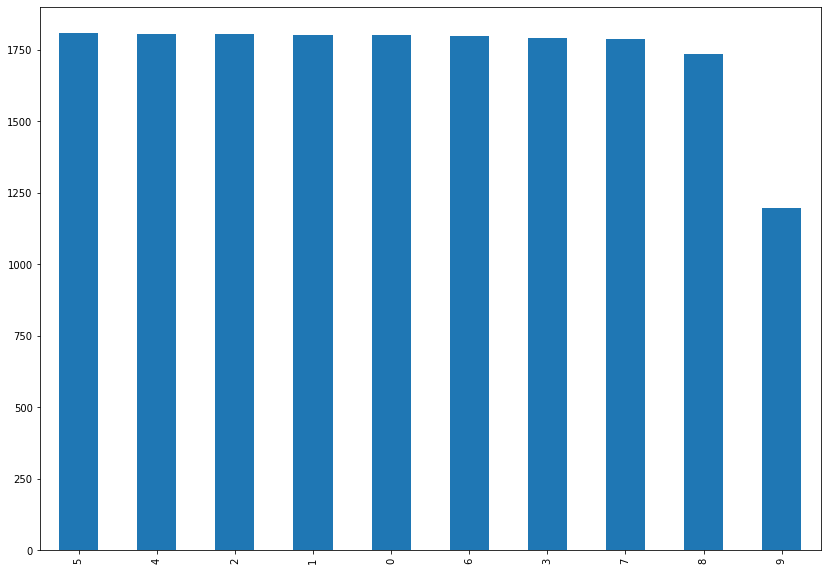

In [7]:
df = dfTreino['category_nro'].value_counts()
print(dfTreino['category_nro'].unique().size)
df.plot.bar(figsize=(14,10))
#'politica', 'economia', 'esporte', 'mundo', 'ilustrada', 'midia', 'tecnologia', 'educação', 'saude', 'ciencia'

In [8]:
%%time
#para w2vec está sem stemizacao
dfPreProc = PreProcessamentoParalelo(dfTreino,mp.cpu_count())
#dfPreProc = preProcessaTextos(dfTreino)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.
[nltk_data]   Unzipping stemmers/rslp.zip.
CPU times: user 1.5 s, sys: 435 ms, total: 1.93 s
Wall time: 4min 19s


In [ ]:
print(dfPreProc.shape)
dfPreProc.head()

(17320, 2)


,text,category_nro
0,jog will smith campeã sup bowl grand final lig futebol americ est unid new orle saint assassin noit dest sáb new orle smith mulh racquel bale após acid trânsit jog resist fer morr local deix trê filh racquel ating doi tir pern encaminh hospit est saúd divulg smith jog saint assin contrat new england patriot cheg jog tim nfl,2
1,após admit equívoc deix méd institut feder result en exam nacion ensin médi inep institut nacion estud pesquis educac divulg dad escol hav fic public orig acord inep divulg result nov escol oferec ensin médi integr educ profiss dua mai méd en ambas priv lic art ofíci paul colégi viscond port segur val sp campu vitór institut feder espírit sant hav obt lug tod escol públic país prov obje fic pos ranking atual segund inep escol not divulg dia outubr result modific nov cálcul pass inclu alun ensin médi integr educ profiss dess instituiç vej aqu planilh result ferrament busc sit minist educ aind cont dad atual acord past plataform atual nest sextaf,7
2,unicamp univers estad campin vai econom cerc r milh mê congel salári profes acim tet paul cúpul univers porém continu receb val acim dess limit constitu determin serv públic estad pod ganh govern gerald alckmin psdb receb atual r mil brut exceç procur cuj tet mai r mil segu regr judici unicamp docent ativ aposent salári mai tet pass ter venc limit após decis tribun justiç segundaf conform antecip folh desembarg câm direit públic derrub limin decis provisór proib univers aplic redu cúpul univers porém dev continu receb alckmin porqu nov profes carg import unicamp têm doi númer matrícul salári difer cad segund unicamp tet aplic cad matrícul dess mod apen salári cúpul administr limit rei josé tad jorg exempl junh salári brut r mil outr r mil nov decis soment prim venc congel unicamp justif salári duplic sob argument cúpul cumpr papel docent dirig temp diz aind possibil acumul venc lev consider som remuneraç extrapol tet aind discuss definitiv julg tce tribun cont est financi basic recurs govern estad unicamp pass dificuldad financ orç cerc r bilh compromet folh pag ideal máx edit artefolhapres adunicamp dire adunicamp associ docent afirm ser contr dupl remuner cúpul reun associ seman pass diss rei prórei ganh gratific represent aument venc sobr congel salári docent entidad diz vai recorr decis tribun justiç stj superi tribun justiç stf supr tribun feder prim secret adunicamp paul oliv corret carr acadêm ser amarr carg polít fic sujeit condiç moment hum polít afirm profes mai salári cheg top carr após ano dedic docent univers paul defend assemble legisl cri tet únic funcion paul assim ocorr est argument hav fug cad vez mai profes pesquis qualific batalh cort salári unicamp vir batalh tribun ano pass univers pass limit pag abril cumpr decis tce adunicamp entr justiç obtev limin mes suspend med ocas argument limit pag desrespeit isonom serv poi procur univers inclu tet isonom docent univers estad feder cuj tet salar mai sustent profes têm direit adquir legisl imped reduç salári fever dest ano justiç emit prim decis mérit cas autoriz cort segund univers entend confirm agor segund inst result unicamp seguir aplic decis tce congel tet salar docent divulg aplic tet salar alv polêm outr univers estad paul fim ano pass usp unesp unicamp entend pod entr cômput vantag salar adquir serv ant emend constitu deix regr cl instituiç pass ent cort serv val exced salári govern exclu vantag adquir ant daquel ano supr tribun feder porém decid outubr tod vantag dev ser consider cômput tet salar contrari lógic univers salári númer exat serv unicamp salári mai govern conhec mê pass univers vinh recus mostr dad julh public sit list númer matrícul salári mil serv ativ aposent inici ocorr após determin justiç bas açã mov folh abert dad assim acontec cas usp,7
3,ano grand fabric ócul real virtual coloc aparelh merc ano câm grau vão cheg mão usu profiss opç disposi captur costur imag tod direç espalhams estand corr ce mai feir tecnolog mund abr port nest quartaf nikon e

In [9]:
dfPreProc_Teste = PreProcessamentoParalelo(dfteste,mp.cpu_count())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


CRIANDO WORD2VEC

In [10]:
''' transformar o texto das noticias em uma lista de n-grams. Usaremos uni-gramas, bi-gramas e tri-gramas
  algoritmo obtido do artigo https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794
'''
lst_corpus, bigrams_detector, trigrams_detector =  obtemListasn_grams(dfPreProc['text'])
lst_corpus_teste, bigrams_teste, trigrams_teste =  obtemListasn_grams(dfPreProc_Teste['text'])

In [ ]:
#lst_corpus = trigrams_detector
#lst_corpus_teste = trigrams_test

In [11]:
tamanho = [len(i) for i in lst_corpus]
print('menor:', min(tamanho),'media:', np.round(np.mean(tamanho),1), 'mediana:',np.median(tamanho), 'maximo:',max(tamanho) )

menor: 1 media: 253.1 mediana: 216.0 maximo: 5235


In [ ]:
[[i,t] for i,t in enumerate(tamanho)][0:10]


[[0, 59],
 [1, 113],
 [2, 465],
 [3, 229],
 [4, 259],
 [5, 412],
 [6, 460],
 [7, 107],
 [8, 25],
 [9, 123]]

In [ ]:
print(list(bigrams_detector.phrasegrams.keys())[0:10])
print(list(trigrams_detector.phrasegrams.keys())[0:10])


[(b'est\xc3\xa1di', b'aqu\xc3\xa1'), (b'dest', b'ter\xc3\xa7'), (b'trof\xc3\xa9u', b'mar'), (b'mar', b'lenk'), (b'm', b'borbolet'), (b'nest', b'ter\xc3\xa7'), (b'parqu', b'aqu\xc3\xa1'), (b'parqu', b'ol\xc3\xadmp'), (b'ter', b'ido'), (b't\xc3\xaanil', b'club')]
[(b'jog', b'rio'), (b'pouc', b'mes'), (b'dest', b'ter\xc3\xa7'), (b'part', b'dest ter\xc3\xa7'), (b'part dest', b'ter\xc3\xa7'), (b'sele', b'ol\xc3\xadmp'), (b'trof\xc3\xa9u', b'mar'), (b'trof\xc3\xa9u', b'mar lenk'), (b'trof\xc3\xa9u mar', b'lenk'), (b'm', b'borbolet')]


In [ ]:
## fit w2v
nlp = gensim.models.word2vec.Word2Vec(sentences=lst_corpus, size=300,   
            window=8, min_count=1, sg=1, iter=30)
nlp.save('./classica_resp/nlp_w2vec.sav')

In [13]:
# obter o vetor da palavra primavera
word = 'primavera'
nlp.wv.__getitem__(word).shape

(300,)

In [12]:
nlp = gensim.models.word2vec.Word2Vec.load('./classica_resp/nlp_w2vec.sav')

# Rede Neural

* Primeiro, transforme o corpus em sequências preenchidas de ids de palavras para obter uma matriz de recursos.
* Em seguida, crie uma matriz de incorporação de forma que o vetor da palavra com id N esteja localizado na enésima linha.
* Finalmente, construa uma rede neural com uma camada de incorporação que pesa cada palavra nas sequências com o vetor correspondente.

In [26]:
#tokenizar: Transformar o corpus pré-processado (lista de n-gramas: lst_corpous) em uma lista de sequência 
max_length=128
X_train, lst_text2seq, dic_vocabulary = tokenizar(lst_corpus, max_length)
X_teste = tokenizar(lst_corpus_teste, max_length)[0]

In [27]:
print(X_train.shape, X_teste.shape)

(17320, 128) (1925, 128)


In [15]:
y_train  = dfPreProc['category_nro']
y_teste = dfPreProc_Teste['category_nro']

In [ ]:
len(dic_vocabulary.keys())

79779

In [ ]:
lst_text2seq[0][0:15]

[40, 1728, 3806, 1407, 1914, 6456, 54, 122, 297, 584, 178, 13, 181, 1061, 8172]

In [ ]:
print(X_train[0], '\n \n', X_train[1])

[  134     1  4458 18415   119  1236  1256   105   139  5927   184     1
 40026  4915  3107 10286  1255   219  4039   455  1909 25586   294  2858
    42   130   375   496  1206  3980   749   134   163  2619 14997  1943
   160    97  2663  3790   403    12    67   524 18415   810   941 25587
 11565   150    14    41  2372  2598   749    45  3660   263  9742    23
    54   257  2663    93  1140    60    62   129  1180  5527  3108   121
    16   524  1327  1598  3980   263  9742   375  1598   749 12477    46
  5928   689    43   122    15   478 40027  1365   160 22350   614   219
    24  1021   793   220 18415     6    26  4739    42   396   372  1725
  1274   330   121  1362  2742     8   710    84     1   259   710  2880
   504  1362  1844  1059    46  2321  4701  1180] 
 
 [  352   237    31   353  2394  1290   288   140  1330   205   431  3225
   238  1080  1970 14998  2709     8  1330  4637   896     9  1428  2256
    23  1045    27     4 18416    47    29   212    35 18416    47    

In [17]:
'''criar uma matriz embedding para usar como peso na rede neural do classificador.
   cada palavra no dicionário das noticias recebá o vetor do word2vec. '''

## inicia uma matrix zerada de shape tamanho do vocabulário x tamanho do vetor
embeddings = np.zeros((len(dic_vocabulary)+1, 300))
for word,idx in dic_vocabulary.items():
    ## atualiza a linha da matriz com o vetor do word2vec nlp.
    try:
        embeddings[idx] =  nlp.wv.__getitem__(word)
    ## se a palavra não estiver em nlp, o vetor de pesos desta palavra ficará zerado.
    except:
        pass

In [18]:
embeddings.shape

(79780, 300)

In [19]:
''' criar a rede neural para o classificador que terá as seguintes camadas:
  * embedding - obtem as sequências (noticias tokenizadas em X_train) como entrada e o 
    vetor de palavras que compõem cada noticia (embeddings) como pesos.
  * simple Attention layer - proposto por Bahdanau, Cho e Bengio, 2014 e também em quase todos os modelos apresentados no estudo bibliográfico - 
    permite entender qual parte do texto é realmente relevante. Captura os pesos de cada instância e ajuda a construir um explicador, sendo que 
    não é necessário para as previsões, apenas para a explicabilidade.
  * Duas camdas de LSTM Bidirecional para modelar a ordem das palaras em uma sequencia em ambas as direções.
  * Duas camadas densas finais que irão prever a probabilidade de cada categoria de notícias.
'''

## code attention layer
def attention_layer(inputs, neurons):
    x = layers.Permute((2,1))(inputs) #permuta a forma (shape) de entrada usando o padrão (2,1)
    x = layers.Dense(neurons, activation="softmax")(x) #executa a função de ativação softmax na matrix de entrada x. Neurons é a qtd de neurônios.
                                                       #output = activation(dot(input, kernel) + bias) input=x, kernel=neurons (pesos)
    x = layers.Permute((2,1), name="attention")(x) 
    x = layers.multiply([inputs, x]) 
    return x

## input
x_in = layers.Input(shape=(max_length,))
print('x_in:', x_in.shape)
## embedding
x = layers.Embedding(input_dim=embeddings.shape[0],  
                     output_dim=embeddings.shape[1], 
                     weights=[embeddings],
                     input_length=max_length, trainable=False)(x_in)
print('x embedding', x.shape)
## apply attention
x = attention_layer(x, neurons=max_length)
print('x attention_layer', x.shape)
## 2 layers of bidirectional lstm
x = layers.Bidirectional(layers.LSTM(units=max_length, dropout=0.2, 
                         return_sequences=True))(x)
print('x LSTM', x.shape)
x = layers.Bidirectional(layers.LSTM(units=max_length, dropout=0.2))(x)
print('x LSTM', x.shape)
## final dense layers
x = layers.Dense(64, activation='relu')(x)
print('x Dense', x.shape)
y_out = layers.Dense(10, activation='softmax')(x)
print('y_out', y_out.shape)
## compile
model = models.Model(x_in, y_out)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

model.summary()
   
  


x_in: (None, 128)
x embedding (None, 128, 300)
x attention_layer (None, 128, 300)
x LSTM (None, 128, 256)
x LSTM (None, 256)
x Dense (None, 64)
y_out (None, 10)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 128, 300)     23934000    input_1[0][0]                    
__________________________________________________________________________________________________
permute (Permute)               (None, 300, 128)     0           embedding[0][0]                  
__________________________________________________________________________________________________
dense (Dense)                   

In [20]:
'''treinando o modelo '''
## encode y
dic_y_mapping = {n:label for n,label in 
                 enumerate(np.unique(y_train))}
inverse_dic = {v:k for k,v in dic_y_mapping.items()}
y_train = np.array([inverse_dic[y] for y in y_train])
## train
training = model.fit(x=X_train, y=y_train, batch_size=256, 
                     epochs=10, shuffle=True, verbose=0, 
                     validation_split=0.1)

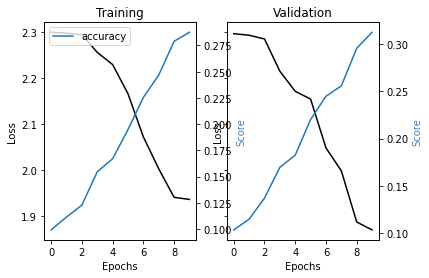

In [21]:
'''loss '''
metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True)
ax[0].set(title="Training")
ax11 = ax[0].twinx()
ax[0].plot(training.history['loss'], color='black')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss', color='black')
for metric in metrics:
    ax11.plot(training.history[metric], label=metric)
ax11.set_ylabel("Score", color='steelblue')
ax11.legend()
ax[1].set(title="Validation")
ax22 = ax[1].twinx()
ax[1].plot(training.history['val_loss'], color='black')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss', color='black')
for metric in metrics:
     ax22.plot(training.history['val_'+metric], label=metric)
ax22.set_ylabel("Score", color="steelblue")
plt.show()

In [44]:
y_pred = model.predict(X_teste)

In [48]:
y_pred_cat = [np.argmax(i) for i in y_pred]
y_pred_prob = [np.max(i) for i in y_pred]


In [50]:
imprimeMetricas(y_pred_cat, y_teste,'./classica_resp/lstm_v1.scr')

Classification Report:
          precision    recall  specificity  f1-score  support
0          0.143443  0.175000     0.878841  0.157658      200
1          0.092593  0.075377     0.914832  0.083102      199
2          0.118012  0.096447     0.917824  0.106145      197
3          0.116667  0.033175     0.969078  0.051661      211
4          0.062500  0.051020     0.913245  0.056180      196
5          0.358779  0.492147     0.903114  0.415011      191
6          0.150763  0.387255     0.741429  0.217033      204
7          0.072115  0.070423     0.887266  0.071259      213
8          0.097222  0.079545     0.925672  0.087500      176
9          0.000000  0.000000     1.000000  0.000000      138
accuracy   0.149610  0.149610     0.905512  0.149610        0
Acurácia: 0.1496103896103896
Acurácia balanceada: 0.14603888371193724
GMean: 0.0
Cohen Kappa Score: 0.051482663629380476
Coef. Correlacao Matheus: 0.05274113086003515
***SALVANDO***
./classica_resp/lstm_v1.scr


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


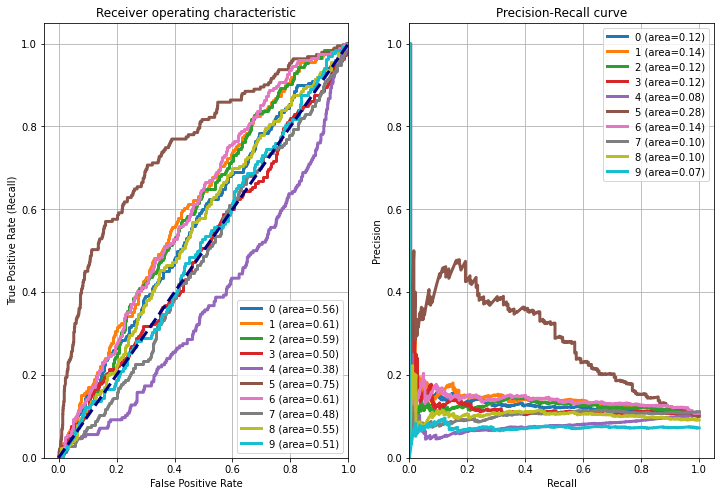

In [53]:
imprimeROC_PrecisonRecall_curvas(y_teste,y_pred)

KNN